In [1]:
%matplotlib inline
import requests
import numpy as np
import pandas as pd
import cycler
import matplotlib.pyplot as plt
from xml.etree import ElementTree
from itertools import chain

In [2]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

## Вспомогательный класс конвертера валют

In [3]:
class ValuteConverter:
    
    def __init__(self, date=None):
        
        ''' date - дата в формате dd/mm/yyyy '''
        
        self.rate = {}
        url = 'http://www.cbr.ru/scripts/XML_daily.asp'
        
        if date != None:
            url += '?date_req=' + date

        r = requests.get(url)
        if r.status_code != requests.codes.ok:
            raise ConnectionError("Service return code " + str(r.status_code))
            
        daily_exchange_rate = ElementTree.fromstring(r.content)
        
        for item in daily_exchange_rate.findall('Valute'):
            code = item.find('CharCode').text
            value = item.find('Value').text
            self.rate[code] = float(value.replace(',', '.'))
                
    def convert(self, count, valute_from):
        
        ''' Переводит указанное число (count) единиц валюты, указанной в ISO (valute_from) в рубли '''
        
        if count == None:
            return None
        
        if valute_from in self.rate:
            return int(count * self.rate[valute_from])
        else:
            raise ValueError("Can't convert valute: " + valute_from)

#### Пример работы

In [4]:
vc = ValuteConverter()
print(vc.convert(4500, 'USD'), 'руб')
print(vc.convert(3624, 'EUR'), 'руб')
print(vc.convert(None, 'USD'), 'руб\n')

vc_old = ValuteConverter('02/03/2002')
print(vc_old.convert(4500, 'USD'), 'руб')
print(vc_old.convert(3624, 'EUR'), 'руб')
print(vc_old.convert(None, 'USD'), 'руб')

254754 руб
252945 руб
None руб

139246 руб
97247 руб
None руб


## Считываем 1000 последних вакансий с hh.ru

One-line challenge!

In [5]:
vacancies = list(chain.from_iterable([requests.get('https://api.hh.ru/vacancies?per_page=100&page=' + str(page)).json()['items'] for page in range(10)]))

In [6]:
print(len(vacancies))

1000


In [7]:
for idx, vacancy in enumerate(vacancies):
    print(vacancy['name'])
    if idx == 10:
        break

Media buyer (Facebook)
Начальник производства
Менеджер отдела продаж
Категорийный менеджер (электротовары)
Менеджер активных продаж
Менеджер по продажам оборудования
Руководитель операционного офиса
Заведующий аптечным пунктом
Фармацевт
Бизнес-аналитик
Менеджер в отдел согласования


## Считываем данные о вакансиях data scientist c hh.ru

In [8]:
vacancies = [] # Список всех вакансий
page = 0       # Текущая считываемая страница
pages = 1      # Всего страниц в выдаче

# Борьба с возможной "пагинацией"
while page != pages:
    params = '?text=Data+scientist&area=113&per_page=100&no_magic=true&page=' + str(page)
    r = requests.get('http://api.hh.ru/vacancies' + params)
    if r.status_code != requests.codes.ok:
        print(color.BOLD + color.RED + 'FATAL: API return ' + str(r.status_code) + ' code!' + color.END)
        break
    data = r.json()
    vacancies += data['items']
    pages = data['pages']
    page += 1
    print('Считываем страницу: %s / %s (%3s элементов)' % (page, data['pages'], len(data['items'])))

Считываем страницу: 1 / 3 (100 элементов)
Считываем страницу: 2 / 3 (100 элементов)
Считываем страницу: 3 / 3 ( 30 элементов)


### Структура полученного словаря

In [9]:
for k in data:
    print(k)

clusters
items
pages
arguments
found
alternate_url
per_page
page


### Структура вакансии

In [10]:
for k in data['items'][0]:
    print(k)
    
print('\n', data['items'][0])

salary
snippet
archived
premium
name
area
url
created_at
alternate_url
apply_alternate_url
relations
employer
response_letter_required
published_at
address
department
sort_point_distance
type
id

 {'salary': None, 'snippet': {'requirement': 'Programming experience in Java, C# or any other statically typed languages (i.e. Scala, Go, etc). <highlighttext>Data</highlighttext> structures and algorithm...', 'responsibility': 'Geo-information systems knowledge. Office library with specialized work-related books and magazines.'}, 'archived': False, 'premium': False, 'name': 'Senior Software Developer (Datalore)', 'area': {'url': 'https://api.hh.ru/areas/1', 'id': '1', 'name': 'Москва'}, 'url': 'https://api.hh.ru/vacancies/24337349?host=hh.ru', 'created_at': '2018-02-28T20:12:10+0300', 'alternate_url': 'https://hh.ru/vacancy/24337349', 'apply_alternate_url': 'https://hh.ru/applicant/vacancy_response?vacancyId=24337349', 'relations': [], 'employer': {'logo_urls': {'90': 'https://hhcdn.ru/employ

### Строим Pandas-DataFrame

Искуственно создаю трудности, убрал параметр "only_with_salary=true" из запроса к API, чтобы заюзать filter

In [11]:
vacancies = list(filter(lambda x: x['salary'] != None, vacancies))

In [12]:
df = pd.DataFrame(vacancies)    # dataframe из вакансий, см. структуру вакансии
df[['name', 'salary', 'area']].head(10)

,name,salary,area
0,Data Scientist,"{'to': 120000, 'gross': True, 'from': 100000, ...","{'url': 'https://api.hh.ru/areas/1', 'id': '1'..."
1,Data Scientist/Finance Quantitative Researcher,"{'to': 120000, 'gross': True, 'from': 90000, '...","{'url': 'https://api.hh.ru/areas/1', 'id': '1'..."
2,Data Scientist (Аналитик),"{'to': 200000, 'gross': False, 'from': 140000,...","{'url': 'https://api.hh.ru/areas/1', 'id': '1'..."
3,Senior data scientist / специалист по машинном...,"{'to': None, 'gross': True, 'from': 140000, 'c...","{'url': 'https://api.hh.ru/areas/1', 'id': '1'..."
4,Специалист по машинному обучению / Data Scientist,"{'to': 150000, 'gross': False, 'from': 60000, ...","{'url': 'https://api.hh.ru/areas/2', 'id': '2'..."
5,Data Scientist/ Аналитик-программист (Python),"{'to': None, 'gross': False, 'from': 130000, '...","{'url': 'https://api.hh.ru/areas/1', 'id': '1'..."
6,Senior Data Scientist (Machine Learning) / Sen...,"{'to': None, 'gross': False, 'from': 200000, '...","{'url': 'https://api.hh.ru/areas/2', 'id': '2'..."
7,Senior Data Scientist (Machine Learning) / Sen...,"{'to': None, 'gross': False, 'from': 200000, '...","{'url': 'https://api.hh.ru/areas/1', 'id': '1'..."
8,Аналитик / Риск-менеджер / Data scientist,"{'to': 80000, 'gross': False, 'from': 60000, '...","{'url': 'https://api.hh.ru/areas/1', 'id': '1'..."
9,Data Scientist (ML/AI/Big Data/Python),"{'to': None, 'gross': False, 'from': 100000, '...","{'url': 'https://api.hh.ru/areas/1', 'id': '1'..."


In [13]:
# Вывод зарплат по вакансиям
print(color.BOLD + color.BLUE + '%-7s %-7s (%s)' % ('From', 'To', 'ISO'), color.END)
for item in df['salary']:
    print('%-7s %-7s (%s)' % (item['from'], item['to'], item['currency']))

From    To      (ISO) 
100000  120000  (RUR)
90000   120000  (RUR)
140000  200000  (RUR)
140000  None    (RUR)
60000   150000  (RUR)
130000  None    (RUR)
200000  None    (RUR)
200000  None    (RUR)
60000   80000   (RUR)
100000  None    (RUR)
50000   160000  (RUR)
60000   None    (RUR)
330000  455000  (RUR)
150000  200000  (RUR)
None    150000  (RUR)
160000  None    (RUR)
300000  None    (RUR)
75000   None    (RUR)
300000  None    (RUR)
None    150000  (RUR)
100000  None    (RUR)
200000  300000  (RUR)
100000  None    (RUR)
80000   150000  (RUR)
None    4500    (USD)
325000  None    (RUR)
170000  None    (RUR)
170000  None    (RUR)
120000  None    (RUR)
120000  None    (RUR)
80000   100000  (RUR)
70000   None    (RUR)
150000  None    (RUR)
100000  None    (RUR)
150000  None    (RUR)
120000  None    (RUR)
170000  None    (RUR)
170000  None    (RUR)
40000   120000  (RUR)
50000   None    (RUR)
2900    3800    (USD)
120000  250000  (RUR)
80000   130000  (RUR)
None    250000  (RUR)
50000   1

### Получаем медианные значения зарплат

In [14]:
def avg_salary(s1, s2):
    if (s1 == None):
        if (s2 == None):
            return None
        return s2
    if (s2 == None):
        return s1
    return (s1 + s2) // 2

In [15]:
def prepare_salary(salary):
    if salary['currency'] != 'RUR':
        salary['to'] = vc.convert(salary['to'], salary['currency'])
        salary['from'] = vc.convert(salary['from'], salary['currency'])
        salary['currency'] = 'RUR'
    salary['avg'] = avg_salary(salary['to'], salary['from'])

In [16]:
df['salary'].apply(prepare_salary) # Аналогично map-функции

print(color.BOLD + color.BLUE + '%-7s %-7s %-7s (%s)' % ('From', 'To', 'Avg', 'ISO'), color.END)
for item in df['salary']:
    print('%-7s %-7s %-7s (%s)' % (item['from'], item['to'], item['avg'], item['currency']))

From    To      Avg     (ISO) 
100000  120000  110000  (RUR)
90000   120000  105000  (RUR)
140000  200000  170000  (RUR)
140000  None    140000  (RUR)
60000   150000  105000  (RUR)
130000  None    130000  (RUR)
200000  None    200000  (RUR)
200000  None    200000  (RUR)
60000   80000   70000   (RUR)
100000  None    100000  (RUR)
50000   160000  105000  (RUR)
60000   None    60000   (RUR)
330000  455000  392500  (RUR)
150000  200000  175000  (RUR)
None    150000  150000  (RUR)
160000  None    160000  (RUR)
300000  None    300000  (RUR)
75000   None    75000   (RUR)
300000  None    300000  (RUR)
None    150000  150000  (RUR)
100000  None    100000  (RUR)
200000  300000  250000  (RUR)
100000  None    100000  (RUR)
80000   150000  115000  (RUR)
None    255604  255604  (RUR)
325000  None    325000  (RUR)
170000  None    170000  (RUR)
170000  None    170000  (RUR)
120000  None    120000  (RUR)
120000  None    120000  (RUR)
80000   100000  90000   (RUR)
70000   None    70000   (RUR)
150000  N

### Строим диаграмму по медианным значениям зарплат

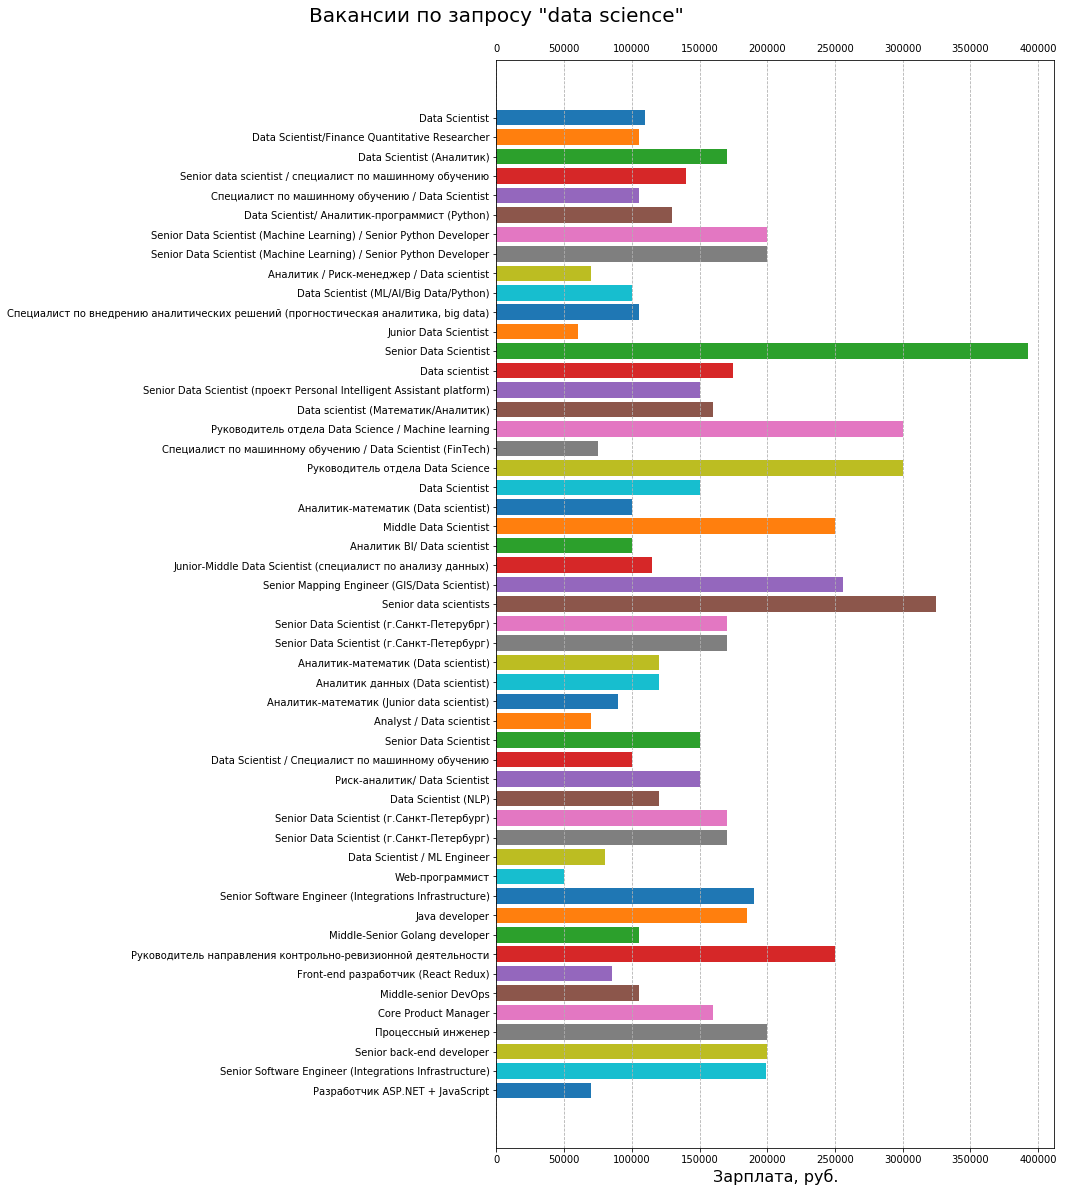

In [17]:
fig, ax = plt.subplots(figsize=(10, 20))

for idx, item in enumerate(df['salary']):
    ax.barh(idx, item['avg'], label=str(idx), zorder=0.1)

ax.set_yticks(range(len(df['salary'])))
ax.set_yticklabels(df['name'])
ax.invert_yaxis()
ax.set_xlabel('Зарплата, руб.', fontsize=16)
ax.set_title('Вакансии по запросу "data science"', x=0, y=1.03, fontsize=20)
ax.set_axisbelow(True)
ax.xaxis.grid(linestyle='--')
ax.tick_params(labeltop=True, labelright=False)
plt.show()

### Получаем распределение зарплат по диапазонам

In [18]:
salary_df = pd.DataFrame(list(df['salary']))
salary_df.head(10)

,avg,currency,from,gross,to
0,110000,RUR,100000.0,True,120000.0
1,105000,RUR,90000.0,True,120000.0
2,170000,RUR,140000.0,False,200000.0
3,140000,RUR,140000.0,True,NaN
4,105000,RUR,60000.0,False,150000.0
5,130000,RUR,130000.0,False,NaN
6,200000,RUR,200000.0,False,NaN
7,200000,RUR,200000.0,False,NaN
8,70000,RUR,60000.0,False,80000.0
9,100000,RUR,100000.0,False,NaN


In [19]:
icount = 10 # Количество интервалов для разбиения

max_val = salary_df['avg'].max()
min_val = salary_df['avg'].min()

print('min = %s\nmax = %s' % (min_val, max_val))

min = 50000
max = 392500


In [20]:
data_d = (max_val - min_val) / icount
bins = [int(min_val + i*data_d) for i in range(icount)]

hist, bins = np.histogram(salary_df['avg'], bins=bins)
bin_counts = zip(bins, bins[1:], hist)

print(color.BOLD + color.BLUE + '%7s-%-7s: %s' % ('left ', ' right', 'count'), color.END)
for bin_start, bin_end, count in bin_counts:
    print('%7s-%-7s: %s' % (bin_start, bin_end, count))

  left - right : count 
  50000-84250  : 7
  84250-118500 : 13
 118500-152750 : 9
 152750-187000 : 9
 187000-221250 : 6
 221250-255500 : 2
 255500-289750 : 1
 289750-324000 : 2
 324000-358250 : 1


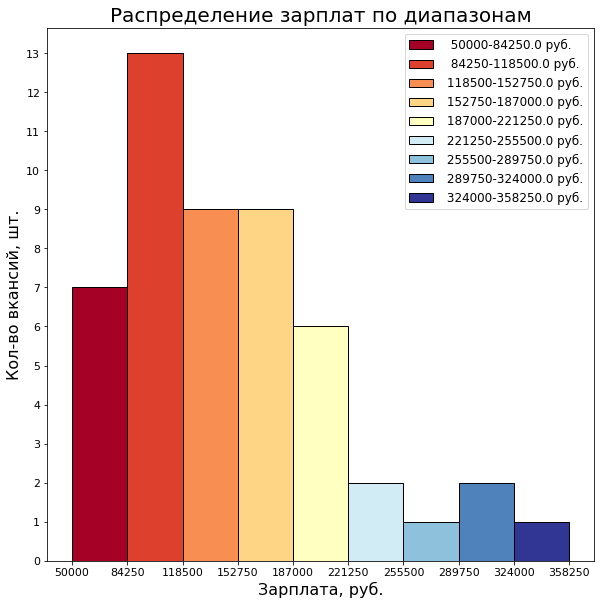

In [21]:
cm = plt.cm.get_cmap('RdYlBu')

plt.figure(figsize=(9.8, 9.8))
plt.title('Распределение зарплат по диапазонам', fontsize=20)
plt.xlabel('Зарплата, руб.', fontsize=16)
plt.xticks(bins, fontsize=11)
plt.ylabel('Кол-во вкансий, шт.', fontsize=16)
plt.yticks(range(len(salary_df['avg'])), fontsize=11)
n, bins, patches = plt.hist(salary_df['avg'], bins, normed=0, edgecolor='black')

bin_centers = 0.5 * (bins[:-1] + bins[1:])
col = bin_centers - min(bin_centers)
col /= max(col)

for c, p, b in zip(col, patches, bins):
    plt.setp(p, 'facecolor', cm(c))
    plt.setp(p, 'label', '%7s-%-7s руб.' % (b, b + data_d))

plt.legend(fontsize=12)
plt.show()

In [22]:
def func(item):
    if item['area']['name'] in unique_cities:
        unique_cities[item['area']['name']][0] += 1
        unique_cities[item['area']['name']][1] += item['salary']['avg']

In [23]:
cities = df['area'].apply(lambda x: x['name'])
unique_cities = {key: [0, 0] for key in cities.unique()}
for key in cities.unique():
    unique_cities[key] = [0, 0]
df.apply(func, axis=1)
unique_cities

{'Екатеринбург': [1, 170000],
 'Липецк': [1, 190283],
 'Москва': [27, 4553104],
 'Нижний Новгород': [1, 170000],
 'Новосибирск': [4, 410000],
 'Омск': [1, 150000],
 'Санкт-Петербург': [15, 1928803],
 'Тюмень': [1, 250000]}

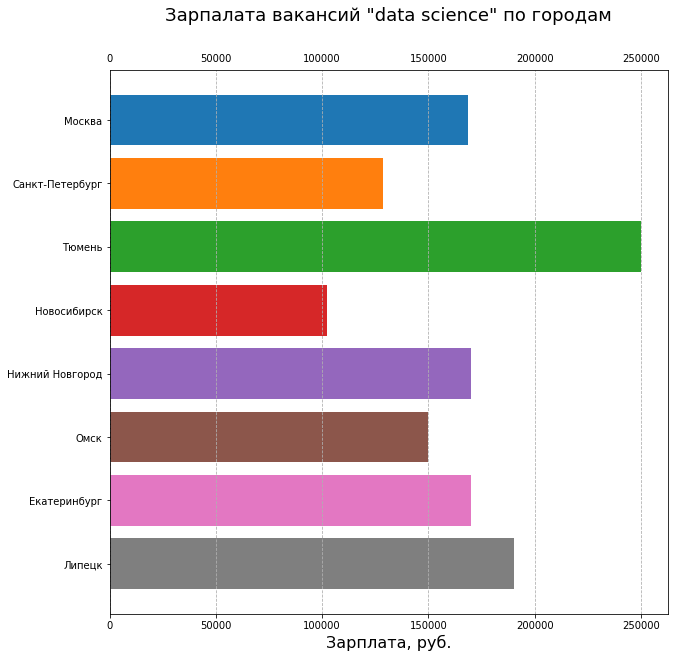

In [24]:
fig, ax = plt.subplots(figsize=(10, 10))

for idx, item in enumerate(unique_cities.values()):
    ax.barh(idx, item[1]//item[0], label=str(idx), zorder=0.1)

ax.set_yticks(range(len(unique_cities)))
ax.set_yticklabels(unique_cities.keys())
ax.invert_yaxis()
ax.set_xlabel('Зарплата, руб.', fontsize=16)
ax.set_title('Зарпалата вакансий "data science" по городам', x=0.5, y=1.08, fontsize=18)
ax.set_axisbelow(True)
ax.xaxis.grid(linestyle='--')
ax.tick_params(labeltop=True, labelright=False)
plt.show()